In [ ]:
!pip install datasets

In [ ]:
import os
import pandas as pf
from datasets import load_dataset
import datasets

from PIL import Image, ImageDraw, ImageFont

from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, GPT2Tokenizer, Trainer, TrainingArguments

import torch
from torch.utils.data import Dataset, random_split

import requests

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Classes

In [ ]:
class cfg :
    ENCODER = "microsoft/swinv2-large-patch4-window12-192-22k"
    DECODER = "gpt2"

    MAX_LEN = 16

    OUTPUT_DIR = "./runs"
    LOG_DIR = "./logs"

    EPOCHS = 5
    TRAIN_BATCH_SIZE = 8
    VAL_BATCH_SIZE = 8
    SAVE_STEPS = 500

    LR = 5e-5

In [ ]:
def collate_fn(batch):
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    labels = torch.tensor([item["input_ids"] for item in batch])
    return {"pixel_values": pixel_values, "labels": labels}

### Dataset

In [ ]:
#images_dataset = load_dataset("flickr8k")

In [ ]:
!wget "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip" -O Flickr8k_Dataset.zip
!unzip Flickr8k_Dataset.zip
!rm -r -f __MACOSX/
!rm -r -f Flickr8k_Dataset.zip

In [ ]:
# #
# images_dataset = []
# for img in os.listdir("Flicker8k_Dataset"):
#   image = Image.open(f"Flicker8k_Dataset/{img}").convert("RGB")
#   image = datasets.Image().encode_example(image)
#   images_dataset.append({"image": image})
# df = pf.DataFrame(images_dataset)
# images_dataset = datasets.Dataset.from_pandas(df)

In [ ]:
images_dataset = []
for img in os.listdir("Flicker8k_Dataset"):
  image_path = os.path.join("/content/Flicker8k_Dataset", img)
  images_dataset.append({"image_path": image_path})
df = pf.DataFrame(images_dataset)
images_dataset = datasets.Dataset.from_pandas(df)

In [ ]:
!wget "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip" -O Flickr8k_text.zip
!unzip Flickr8k_text.zip -d Flickr8k_text

In [ ]:
!cp Flickr8k_text/Flickr8k.token.txt ./captions.txt
!rm -r -f Flickr8k_text

In [ ]:
captions = []
raw_captions = open("captions.txt", "r").read()
raw_captions = raw_captions.split("\n")
for c in raw_captions:
  if "#0" in c:
    captions.append(c.split("\t")[1])

In [ ]:
class Flickr8kDataset(Dataset):
    def __init__(self, flicker_images, captions, feature_extractor, tokenizer, max_length):
        self.images = flicker_images
        self.captions = captions
        self.feature_extractor = feature_extractor
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.images)

    def preprocess_image(self, image):
        return self.feature_extractor(images=image, return_tensors="pt").pixel_values[0]

    def preprocess_text(self, text):
        return self.tokenizer(text, max_length=self.max_length, padding="max_length", truncation=True).input_ids

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]["image_path"]).convert("RGB")
        caption = self.captions[idx]
        pixel_values = self.preprocess_image(image)
        input_ids = self.preprocess_text(caption)
        return {"pixel_values": pixel_values, "input_ids": input_ids}

### Train

In [ ]:
device = torch.device("cuda:0")

In [ ]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(cfg.ENCODER, cfg.DECODER, device_map="auto")

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained(cfg.ENCODER)
tokenizer = GPT2Tokenizer.from_pretrained(cfg.DECODER)

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.decoder.config.vocab_size
model.config.eos_token_id = tokenizer.eos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.max_length = cfg.MAX_LEN
model.config.no_repeat_ngram_size = 2

In [ ]:
training_args = TrainingArguments(
    output_dir= cfg.OUTPUT_DIR,
    eval_strategy="epoch",
    per_device_train_batch_size= cfg.TRAIN_BATCH_SIZE,
    per_device_eval_batch_size= cfg.VAL_BATCH_SIZE,
    num_train_epochs= cfg.EPOCHS,
    save_steps= cfg.SAVE_STEPS,
    logging_dir= cfg.LOG_DIR,
    learning_rate= cfg.LR,
    remove_unused_columns= False
)

In [ ]:
dataset = Flickr8kDataset(images_dataset, captions, feature_extractor, tokenizer, cfg.MAX_LEN)
train_dataset, test_dataset = random_split(dataset, [0.9, 0.1])

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=collate_fn
)

In [ ]:
trainer.train()

In [70]:
!rm -r -f "/content/drive/MyDrive/AUB Research/VIP/Models/swinv2_l_192_22k_gpt2_500"

### Test


In [60]:
model = VisionEncoderDecoderModel.from_pretrained("/content/drive/MyDrive/AUB Research/VIP/Models/swinv2_l_192_22k_gpt2_500")
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

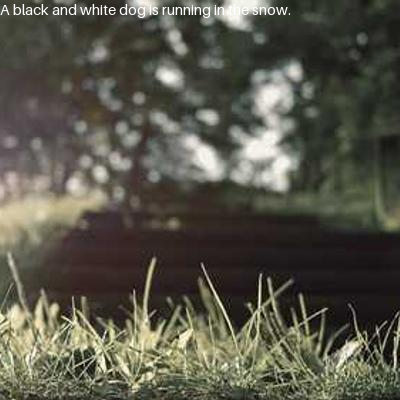

In [68]:
image_url = "https://picsum.photos/400"
image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")

pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)
output_ids = model.generate(pixel_values, max_length=16, num_beams=4, repetition_penalty=2.5)
caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)

draw = ImageDraw.Draw(image)
font = ImageFont.load_default(15)
draw.text((0, 0), caption ,(255,255,255),font=font)

image